In [4]:
import requests
import lxml.html as lx
import requests_cache
requests_cache.install_cache("final_project_cache")
import tqdm
import time
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import re
import pandas as pd
from bokeh.plotting import figure, show, output_file, output_notebook, save
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.io import show, output_notebook,output_file
from bokeh.palettes import OrRd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import csv
import urllib
from time import sleep
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
%matplotlib inline
import plotnine as p9
from fuzzywuzzy import process
import pycountry
import geopandas as gpd
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liufanling/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/liufanling/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liufanling/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Retrive and store data**

In [84]:
# fetch all information from google scholar
def fetch_info(page_url):
    response = requests.get(page_url)
    response.raise_for_status()
    page_html = lx.fromstring(response.text)
    title_elements = page_html.xpath('//h3[@class="gs_rt"]/a')
    title = [title.text_content() for title in title_elements]
    author_elements = page_html.xpath('//div[@class="gs_a"]')
    author = [a.text_content() for a in author_elements]
    author_url_elements = page_html.xpath('//div[@class="gs_a"]/a/@href')
    author_url = [f'https://scholar.google.com/{a}' for a in author_url_elements]
    abstract_elements = page_html.xpath('//div[@class="gs_rs"]')
    abstract = [element.text_content().replace('…', '').replace('\n', '') for element in abstract_elements]
    return title, author, author_url, abstract

In [85]:
def fetch_google(lower, upper):
    title_list = np.array([])
    author_list = np.array([])
    author_url_list = np.array([])
    abstract_list = np.array([])
    for page_num in range(lower, upper):
        start_index = page_num * 10  # Calculate the start index for each page
        page_url = f'https://scholar.google.com/scholar?start={start_index}&q=deep+learning&hl=zh-CN&as_sdt=0,5&as_ylo=2023&as_yhi=2024'
        title, author, author_url, abstract = fetch_info(page_url)
        title_list = np.append(title_list, title)
        author_list = np.append(author_list, author)
        author_url_list = np.append(author_url_list, author_url)
        abstract_list = np.append(abstract_list, abstract)
        time.sleep(1)
    return title_list, author_list, author_url_list, abstract_list

In [86]:
fetch_50 = fetch_google(0, 50)

In [126]:
google_title = fetch_50[0]
google_author = fetch_50[1]
google_author_url = fetch_50[2]
google_abstract = fetch_50[3]

In [127]:
# store into csv
filename = "google_data.csv"

max_length = max(len(google_title), len(google_author), len(google_author_url), len(google_abstract))

# Open the CSV file in write mode
with open('google_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(["Google Title", "Google Author", "Google Author URL", "Google Abstract"])

    # Iterate up to the length of the longest list
    for i in range(max_length):
        # For each column, write the data if present, or write an empty string
        row = [
            google_title[i] if i < len(google_title) else '',
            google_author[i] if i < len(google_author) else '',
            google_author_url[i] if i < len(google_author_url) else '',
            google_abstract[i] if i < len(google_abstract) else ''
        ]
        writer.writerow(row)

In [118]:
# fetch all information from arxiv
def fetch_arxiv_info(page_url):
    response = requests.get(page_url)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    title_elements = html.xpath('//p[@class="title is-5 mathjax"]')
    title = [re.sub(r'\s+', ' ', t.text_content().strip()) for t in title_elements]
    author_elements = html.xpath('//p[@class="authors"]')
    author = [re.sub(r'\s+', ' ', a.text_content().strip()) for a in author_elements]
    author_url_elements = html.xpath('//p[@class="authors"]/a/@href')
    author_url = [f'https://arxiv.org{a}' for a in author_url_elements]
    abstract_elements = html.xpath('//span[@class="abstract-full has-text-grey-dark mathjax"]')
    abstract = [re.sub(r'\s+', ' ', element.text_content().strip()) for element in abstract_elements]
    return title, author, author_url, abstract

In [119]:
# fetch from arxiv by page
def fetch_arxiv(lower, upper):
    title_list = np.array([])
    author_list = np.array([])
    author_url_list = np.array([])
    abstract_list = np.array([])
    for page_num in range(lower, upper):
        start_index = page_num * 200  # Calculate the start index for each page
        page_url = f'https://arxiv.org/search/?searchtype=all&query=deep+learning&abstracts=show&size=200&order=&start={start_index}'
        title, author, author_url, abstract = fetch_arxiv_info(page_url)
        title_list = np.append(title_list, title)
        author_list = np.append(author_list, author)
        author_url_list = np.append(author_url_list, author_url)
        abstract_list = np.append(abstract_list, abstract)
        time.sleep(1)
    return title_list, author_list, author_url_list, abstract_list

In [120]:
fetch_50_arxiv = fetch_arxiv(0, 50)

In [121]:
arxiv_title = fetch_50_arxiv[0]
arxiv_author = fetch_50_arxiv[1]
arxiv_author_url = fetch_50_arxiv[2]
arxiv_abstract = fetch_50_arxiv[3]

In [122]:
# store into csv
filename = "arxiv_data.csv"

max_length = max(len(arxiv_title), len(arxiv_author), len(arxiv_author_url), len(arxiv_abstract))

# Open the CSV file in write mode
with open('arxiv_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(["Arxiv Title", "Arxiv Author", "Arxiv Author URL", "Arxiv Abstract"])

    # Iterate up to the length of the longest list
    for i in range(max_length):
        # For each column, write the data if present, or write an empty string
        row = [
            arxiv_title[i] if i < len(arxiv_title) else '',
            arxiv_author[i] if i < len(arxiv_author) else '',
            arxiv_author_url[i] if i < len(arxiv_author_url) else '',
            arxiv_abstract[i] if i < len(arxiv_abstract) else ''
        ]
        writer.writerow(row)

In [239]:
def fetch_biorxiv_info(page_url):
    response = requests.get(page_url)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    titles = np.empty(75, dtype=object)
    title_elements = html.xpath('//a[@class="highwire-cite-linked-title"]')
    for i, title_element in enumerate(title_elements):
        titles[i] = title_element.text_content().strip()
    # authors = np.empty(75, dtype=object)
    # author_elements = html.xpath('//span[@class="highwire-citation-authors"]')
    # for i, author_element in enumerate(author_elements):
    #     authors[i] = author_element.text_content().strip()
    abstract_links = html.xpath('//a[@class="highwire-cite-linked-title"]/@href')
    abstract_links = ['https://www.biorxiv.org' + link for link in abstract_links]
    abstracts = np.empty(len(abstract_links), dtype=object)
    for i, link in enumerate(abstract_links):
        response = requests.get(link)
        response.raise_for_status()
        html = lx.fromstring(response.text)
        abstract_elements = html.xpath('//div[@class="section abstract"]')
        if abstract_elements:
            abstracts[i] = abstract_elements[0].text_content().strip().replace("Abstract", "", 1)
        else:
            abstracts[i] = ""
        time.sleep(0.2)
    return titles, abstracts
                                

In [245]:
def fetch_biorxiv(lower, upper):
    title_list = np.array([])
    # author_list = np.array([])
    abstract_list = np.array([])
    for page_num in range(lower, upper):
        page_url = f'https://www.biorxiv.org/search/deep%2Blearning%20numresults%3A75%20sort%3Arelevance-rank?page={page_num}'
        title, abstract = fetch_biorxiv_info(page_url)
        title_list = np.append(title_list, title)
        # author_list = np.append(author_list, author)
        abstract_list = np.append(abstract_list, abstract)
        time.sleep(1)
    return title_list, abstract_list

In [259]:
fetch_5_biorxiv = fetch_biorxiv(0, 5)

In [440]:
bioarxiv_title = fetch_5_biorxiv[0]
bioarxiv_abstract = fetch_5_biorxiv[1]

In [441]:
# store into csv
filename = "bioarxiv_data.csv"

# Open the file in write mode
with open(filename, 'w', newline='') as csvfile:
    # Create a csv writer object
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(["Bioarxiv Title", "Bioarxiv Abstract"])

    # Write the data rows
    for i in range(len(bioarxiv_title)):
        writer.writerow([bioarxiv_title[i], bioarxiv_abstract[i]])

In [ ]:
# Get pubmed abstracts
base_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
db = 'db=pubmed'
query = "Deep+Learning"

# ESearch settings
search_eutil = 'esearch.fcgi?'
search_term = '&term=' + query
search_usehistory = '&usehistory=y'
search_rettype = '&rettype=json'

# Construct the ESearch URL and fetch the data
search_url = base_url + search_eutil + db + search_term + search_usehistory + search_rettype
print("ESearch URL:\n" + search_url + "\n")
f = urllib.request.urlopen(search_url)
search_data = f.read().decode('utf-8')

# Parse out necessary parameters from ESearch result
webenv = re.findall("<WebEnv>(\S+)</WebEnv>", search_data)[0]
query_key = re.findall("<QueryKey>(\d+)</QueryKey>", search_data)[0]

# EFetch settings
fetch_eutil = 'efetch.fcgi?'
retmax = 20  # Number of abstracts fetched per request
total_required = 10000  # Total abstracts required
all_abstracts = []

# Fetch abstracts in batches
for retstart in range(0, total_required, retmax):
    print(f"Fetching abstracts {retstart} to {retstart + retmax}")
    fetch_url = f"{base_url}{fetch_eutil}{db}&query_key={query_key}&WebEnv={webenv}&retstart={retstart}&retmax={retmax}&retmode=text&rettype=abstract"
    print(fetch_url)
    f = urllib.request.urlopen(fetch_url)
    fetch_data = f.read().decode('utf-8')

    # Split the data into individual abstracts and append them to the list
    abstracts = fetch_data.strip().split("\n\n\n")[:-1]  # Exclude last empty split
    all_abstracts.extend(abstracts)

    # Status update
    print(f"A total of {len(all_abstracts)} abstracts have been downloaded.\n")
    
    # Break if the total count is reached or exceeded
    if len(all_abstracts) >= total_required:
        break

    # Pause between requests to avoid being blocked
    sleep(2)

# Confirm final count
print(f"Final count of downloaded abstracts: {len(all_abstracts)}")


In [534]:
len(all_abstracts)

9499

In [535]:
with open("pubmed_abstracts.csv", "wt") as abstracts_file:
    abstract_writer = csv.writer(abstracts_file)
    abstract_writer.writerow(['Journal', 'Title', 'Authors', 'Author_Information', 'Abstract', 'DOI', 'Misc'])
    #For each abstract, split into categories and write it to the csv file
    for abstract in all_abstracts:
        #To obtain categories, split every double newline.
        split_abstract = abstract.split("\n\n")
        abstract_writer.writerow(split_abstract)


In [536]:
with open("pubmed_abstracts.csv", "wt") as abstracts_file, open ("partial_abstracts.csv", "wt") as partial_abstracts:
    # csv writer for full pubmed_abstracts
    abstract_writer = csv.writer(abstracts_file)
    abstract_writer.writerow(['Journal', 'Title', 'Authors', 'Author_Information', 'Abstract', 'DOI', 'Misc'])
    # csv writer for partial pubmed_abstracts
    partial_abstract_writer = csv.writer(partial_abstracts)
    #For each abstract, split into categories and write it to the csv file
    for abstract in all_abstracts:
        #To obtain categories, split every double newline.
        split_abstract = abstract.split("\n\n")
        if len(split_abstract) > 5:
            abstract_writer.writerow(split_abstract)
        else:
            partial_abstract_writer.writerow(split_abstract)

In [ ]:
# Pubmed fecth
# download th csv that contains the information of the articles
# get 10,000 articles from 2023-2024
pubmed_df = pd.read_csv('pubmed.csv')
pubmed_title = pubmed_df['Title'].values

**Title frequency analysis**

In [13]:
# read the csv file
# google
google_df = pd.read_csv('google_data.csv')
google_title = google_df['Google Title'].values
google_author = google_df['Google Author'].values
google_author_url = google_df['Google Author URL'].values
google_abstract = google_df['Google Abstract'].values

# arxiv
arxiv_df = pd.read_csv('arxiv_data.csv')
arxiv_title = arxiv_df['Arxiv Title'].values
arxiv_author = arxiv_df['Arxiv Author'].values
arxiv_author_url = arxiv_df['Arxiv Author URL'].values
arxiv_abstract = arxiv_df['Arxiv Abstract'].values

# bioarxiv
bioarxiv_df = pd.read_csv('bioarxiv_data.csv')
bioarxiv_title = bioarxiv_df['Bioarxiv Title'].values
bioarxiv_abstract = bioarxiv_df['Bioarxiv Abstract'].values

# pubmed
pubmed_df = pd.read_csv('pubmed.csv')
pubmed_title = pubmed_df['Title'].values
pubmed_author = pd.read_csv('pubmed_abstracts.csv', usecols=['Authors']).values
pubmed_abstract = pd.read_csv('pubmed_abstracts.csv', usecols=['Abstract']).values


In [14]:
# remove duplicates
# google
google_title = np.unique(google_title.astype(str))
google_author = np.unique(google_author.astype(str))
google_author_url = np.unique(google_author_url.astype(str))
google_abstract = np.unique(google_abstract.astype(str))

# arxiv
arxiv_title = np.unique(arxiv_title.astype(str))
arxiv_author = np.unique(arxiv_author.astype(str))
arxiv_author_url = np.unique(arxiv_author_url.astype(str))
arxiv_abstract = np.unique(arxiv_abstract.astype(str))

# bioarxiv
bioarxiv_title = np.unique(bioarxiv_title)
bioarxiv_abstract = np.unique(bioarxiv_abstract)

# pubmed
pubmed_title = np.unique(pubmed_title)
split_authors = [author.strip().replace('.', '') for sublist in pubmed_author for entry in sublist for author in entry.split(',')]
pubmed_author = np.unique(split_authors)
pubmed_abstract = np.unique(pubmed_abstract)

In [5]:
# number of papers
print(f"{len(google_title)} of google articles, {len(arxiv_title)} of arxiv articles, {len(bioarxiv_title)} of bioarxiv articles, {len(pubmed_title)} of pubmed articles")

501 of google articles, 9913 of arxiv articles, 375 of bioarxiv articles, 9977 of pubmed articles


In [8]:
# number of authors
print(f"{len(google_author_url)} of google authors, {len(arxiv_author_url)} of arxiv authors, {len(split_authors)} of pubmed authors")

1198 of google authors, 24147 of arxiv authors, 56985 of pubmed authors


In [7]:
# Combine all the titles
all_titles = np.concatenate([google_title, arxiv_title, bioarxiv_title, pubmed_title])
all_titles = np.unique(all_titles) # remove duplicates
len(all_titles)

20600

In [7]:
# standardize the title
def standardize_text(texts):
    # Initialize stop words and the stemmer
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()

    # Remove punctuation
    texts = [re.sub(r'[^\w\s]', '', text) for text in texts]
    # Remove stop words
    texts = [' '.join([word for word in text.split() if word.lower() not in stop_words]) for text in texts]
    # Convert to lowercase
    texts = [text.lower() for text in texts]
    # Remove digits
    # texts = [re.sub(r'\d+', '', text) for text in texts]
    # Remove extra spaces
    texts = [re.sub(r'\s+', ' ', text) for text in texts]
    # Remove leading and trailing spaces
    texts = [text.strip() for text in texts]
    # Remove empty strings
    texts = [text for text in texts if text]
    # Stemming
    texts = [' '.join([stemmer.stem(word) for word in text.split()]) for text in texts]
    # lemmatization
    texts = [' '.join([lemmatizer.lemmatize(word) for word in title.split()]) for title in texts]
    # remove deep learning
    texts = [' '.join([word for word in text.split() if word.lower() != 'deep' and word.lower() != 'learn' and word.lower() != 'deeplearn']) for text in texts]
    return texts


In [8]:
title_std = standardize_text(all_titles)

In [9]:
# Turn the text of titles into a bag of words
title_word = ' '.join(title_std)
title_word = nltk.word_tokenize(title_word)
len(set(title_word))

17752

In [10]:
# get the frequency of the words
fq = nltk.FreqDist(title_word)

In [11]:
# get the most common 10 words
fq.most_common(10)

[('use', 3506),
 ('model', 3137),
 ('imag', 3128),
 ('network', 2438),
 ('predict', 2300),
 ('detect', 2017),
 ('base', 1809),
 ('neural', 1671),
 ('classif', 1305),
 ('segment', 1220)]

In [12]:
# get the words that only appear once
fq.hapaxes()
len(fq.hapaxes())

10900

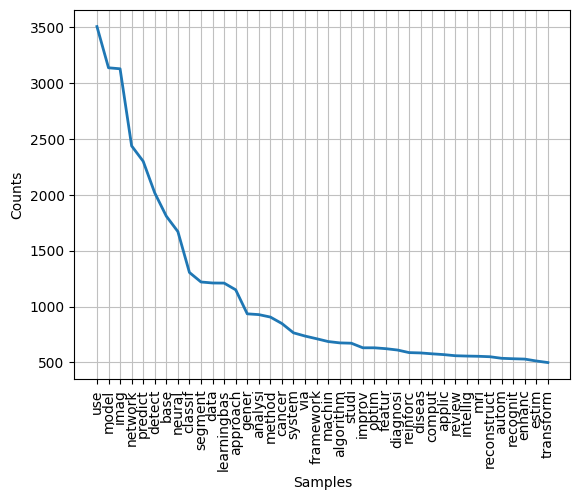

<Axes: xlabel='Samples', ylabel='Counts'>

In [13]:
# plot the frequency of the words (40 most common words)
fq.plot(40)

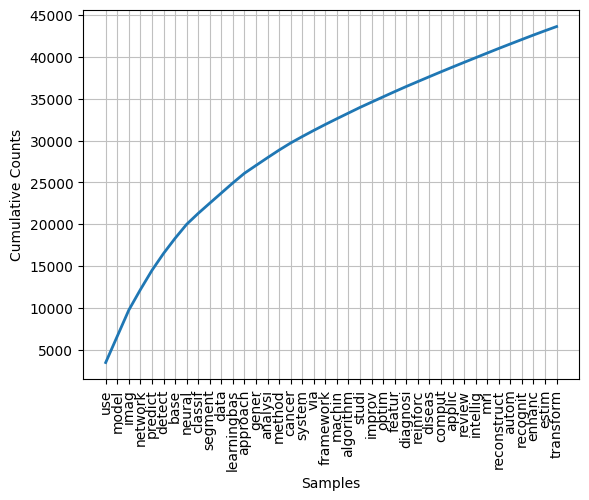

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

In [14]:
# plot the frequency of the words (40 most common words) in cumulative
fq.plot(40, cumulative=True)

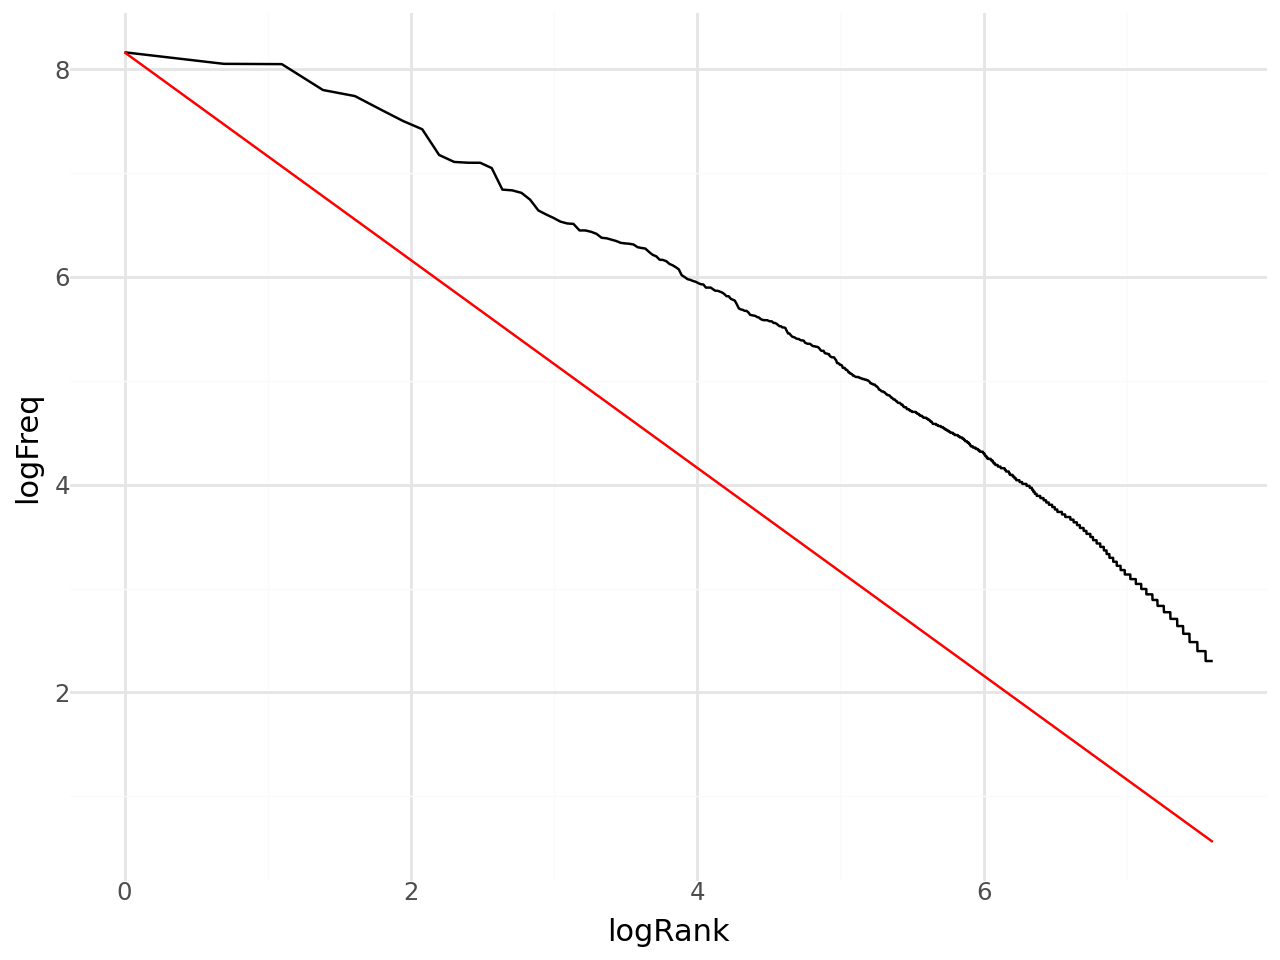

In [15]:
# plot the frequency of the words (40 most common words) in log-log scale
logFreq = [np.log(i[1]) for i in fq.most_common(2000)]
logRank = [np.log(1 + i) for i in range(0,2000)]
a = fq.most_common(1)
a = a[0][1]
np.log(a)
logFreq[0:10]
logTheo = [np.log(1/(1 + i)) for i in range(0,2000)] + logFreq[0]
(
p9.ggplot() + p9.theme_minimal() + 
    p9.geom_line(p9.aes(x='logRank', y='logFreq')) + 
    p9.geom_line(p9.aes(x='logRank', y='logTheo'), color = 'red') 
)

In [ ]:
# vec = CountVectorizer(tokenizer = nltk.word_tokenize)
# freq = vec.fit_transform(title_word)

**Abstract analysis and topic modelling**

In [15]:
# combine all the abstracts
all_abstracts = np.concatenate([google_abstract, arxiv_abstract, bioarxiv_abstract, pubmed_abstract])
all_abstracts = np.unique(all_abstracts) # remove duplicates
len(all_abstracts)

19432

In [16]:
# standardize the abstracts
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def preprocess_abstract(text):
    tokens = word_tokenize(text.lower())
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(lemmatized)

processed_abstracts = [preprocess_abstract(abstract) for abstract in all_abstracts]

In [28]:
# Prepare Texts for LDA
# Tokenize the standardized abstracts
texts = [word_tokenize(abstract) for abstract in processed_abstracts]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)

# Filter out words that occur in less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Create a bag-of-words model for each document
corpus = [dictionary.doc2bow(text) for text in texts]

In [30]:
# Topic Modeling with LDA
# Number of topics
num_topics = 5

# Train the LDA model
lda_model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Print the topics
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.014*"study" + 0.013*"ai" + 0.011*"patient" + 0.010*"research"')
(1, '0.011*"data" + 0.011*"prediction" + 0.008*"study" + 0.008*"using"')
(2, '0.016*"network" + 0.010*"neural" + 0.008*"algorithm" + 0.007*"system"')
(3, '0.015*"data" + 0.013*"image" + 0.012*"feature" + 0.009*"performance"')
(4, '0.031*"image" + 0.013*"segmentation" + 0.013*"using" + 0.010*"result"')


In [ ]:
# Prepare visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Save the visualization to a file
pyLDAvis.save_html(vis, 'topic_lda_visualization.html')

# Display the interactive visualization
pyLDAvis.display(vis)

**Journal frquency check**

In [16]:
# Most frequent Journal
pubmed_journal = pubmed_df['Journal/Book'].values
fq_jnl = nltk.FreqDist(pubmed_journal)
fq_jnl.most_common(10)

[('Sensors (Basel)', 531),
 ('Sci Rep', 407),
 ('Diagnostics (Basel)', 208),
 ('Comput Biol Med', 171),
 ('Eur Radiol', 149),
 ('PLoS One', 136),
 ('Comput Intell Neurosci', 134),
 ('Heliyon', 122),
 ('Med Phys', 111),
 ('Brief Bioinform', 105)]

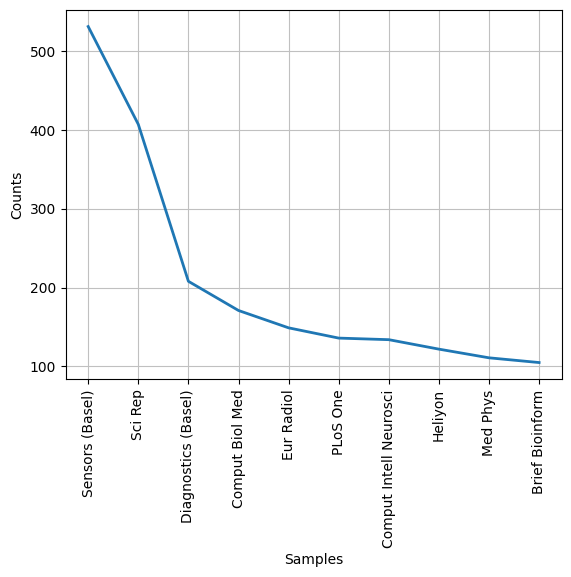

<Axes: xlabel='Samples', ylabel='Counts'>

In [17]:
# plot 10 most frequent journal
fq_jnl.plot(10)

/var/folders/hz/mtvvz9t52kxgqcx423vlrhx00000gn/T/ipykernel_7423/3582888943.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



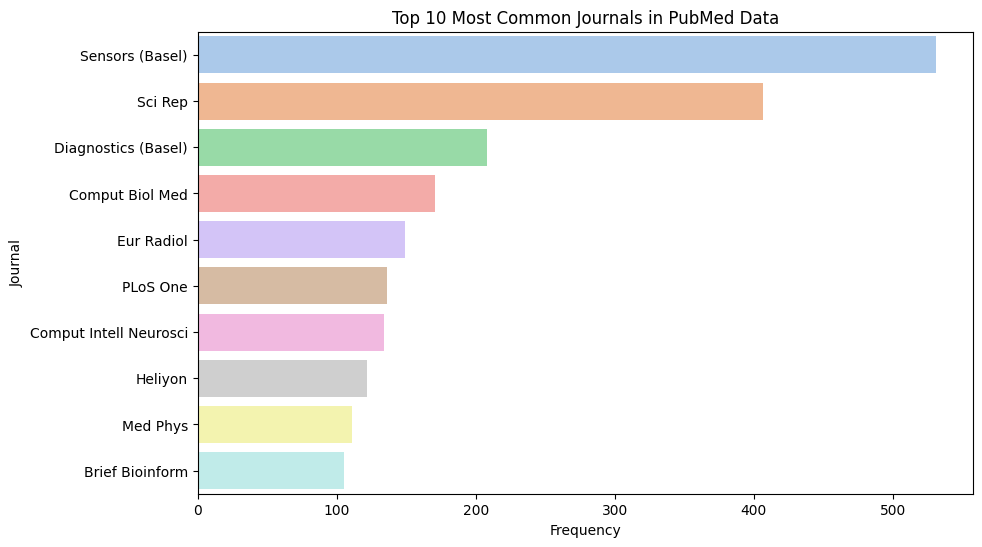

In [211]:
# Most frequent Journal plot 2
# Convert this data into a DataFrame for easier plotting
most_common_journals = fq_jnl.most_common(10)
journals_df = pd.DataFrame(most_common_journals, columns=['Journal', 'Frequency'])

# Create a bar plot with the custom palette
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Journal', data=journals_df, palette='pastel')

plt.title('Top 10 Most Common Journals in PubMed Data')
plt.xlabel('Frequency')
plt.ylabel('Journal')

# Save the plot
plt.savefig('top_10_journals_pubmed_macaron.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

**Institution Publication Analysis**

In [18]:
# author information (institution)
author_information_series = pd.read_csv('pubmed_abstracts.csv', usecols=['Author_Information'])
pubmed_author_info = author_information_series['Author_Information'].to_numpy()
# abstract
abstract_series = pd.read_csv('pubmed_abstracts.csv', usecols=['Abstract'])
pubmed_abstract = abstract_series['Abstract'].to_numpy()
# remove \n
pubmed_abstract = [s.replace('\n', '') for s in pubmed_abstract]

In [19]:
# Institutionins
institution = list(pubmed_author_info)
institution = [s.replace('\n', '') for s in institution] # remove \n
# remove "Author information: "
institution = [s.replace('Author' 'information:', '') for s in institution]
pattern = r"\)([^.]+)\."
# Extract and clean institution names from each text
institution_lists = []
for author_info in institution:
    matches = re.findall(pattern, author_info)
    institutions = [match.strip() for match in matches]
    institution_lists.append(institutions)
institution_lists
# make sure for each publication, the institution is unique
institution_lists = [list(set(institutions)) for institutions in institution_lists]

# flatten the list
institution_lists = [item for sublist in institution_lists for item in sublist]
len(institution_lists)

32950

In [20]:
# write institution_lists to csv
filename = "institution_list.csv"

# Open the file in write mode
with open(filename , 'w', newline='') as csvfile:
    # Create a csv writer object
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(["Institution"])

    # Write the data rows
    for i in range(len(institution_lists)):
        writer.writerow([institution_lists[i]])

In [28]:
# get pure institution
def extract_pure_institutions(institution_list, exclusion_keywords=['department', 'school']):
    city_country_pattern = r",\s*([^,]+)(?:, \d+)?,\s*([^,]+)$"
    
    # Initialize a list to store the processed institution names
    extracted_institutions = []
    
    for item in institution_list:
        # Remove city and country information
        institution_name = re.sub(city_country_pattern, '', item).strip()
    
        # Split the name into segments based on commas
        segments = institution_name.split(', ')
        
        # Check for exclusion keywords in single-segment entries
        if len(segments) == 1 and any(keyword in segments[0].lower() for keyword in exclusion_keywords):
            continue  # Skip entries that match the exclusion criteria
        elif institution_name and len(institution_name.split()) > 1:
            # Remove digits and proceed if there are more than one word
            institution_name = re.sub(r'\d+', '', institution_name).strip()
            extracted_institutions.append(institution_name)
    
    # Remove empty strings and duplicates
    extracted_institutions = [institution for institution in extracted_institutions if institution]
    return extracted_institutions

In [29]:
# pure institution
extracted_institutions = extract_pure_institutions(institution_lists)

In [30]:
len(extracted_institutions)

31920

In [31]:
unique_institutions = list(set(extracted_institutions))

In [32]:
len(unique_institutions)

27976

In [33]:
# check the most common institutions
fq_institute = nltk.FreqDist(extracted_institutions)
fq_institute.most_common(20)

[('University of Chinese Academy of Sciences', 39),
 ('School of Software, Shandong University', 12),
 ('Department of Information Systems, College of Computer and Information Sciences',
  12),
 ('College of Computer Science and Electronic Engineering, Hunan University',
  11),
 ('School of Computer Science and Engineering, Central South University', 11),
 ('Faculty of Applied Sciences, Macao Polytechnic University', 11),
 ('Department of Radiology, Seoul National University Hospital', 10),
 ('Athinoula A', 10),
 ('Department of Biomedical Engineering, Yale University, New Haven', 9),
 ('Department of Oncology, Shanghai Medical College, Fudan University', 9),
 ('Shenzhen Institute of Advanced Technology, Chinese Academy of Sciences', 9),
 ('School of Health Science and Engineering, University of Shanghai for Science and Technology',
  9),
 ('Department of Radiology, Mayo Clinic, Rochester', 9),
 ('School of Medical Technology, Beijing Institute of Technology', 9),
 ('Department of Comp

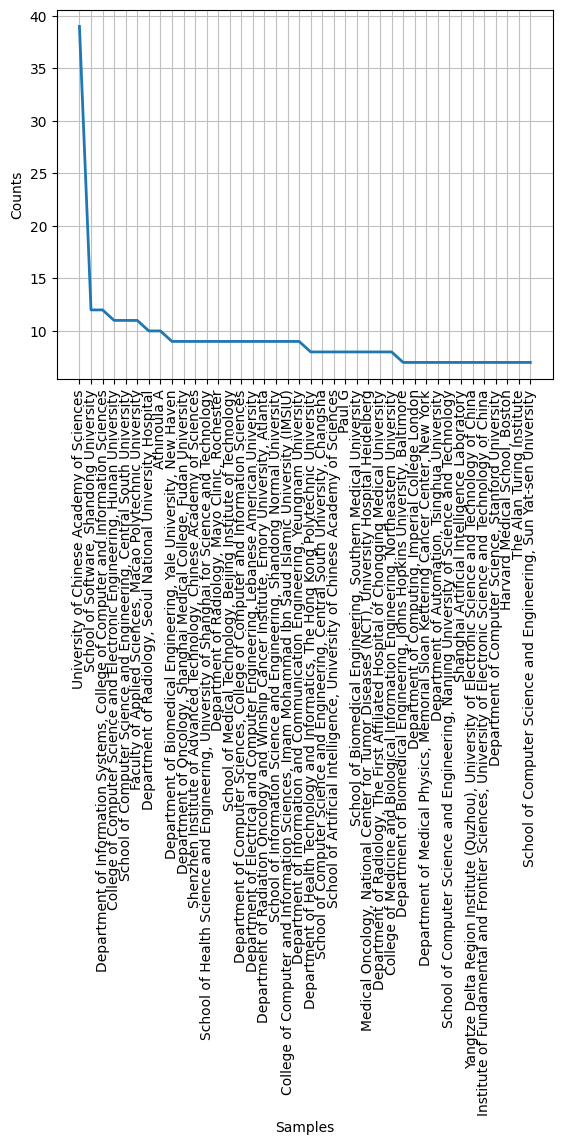

<Axes: xlabel='Samples', ylabel='Counts'>

In [34]:
fq_institute.plot(40)

/var/folders/hz/mtvvz9t52kxgqcx423vlrhx00000gn/T/ipykernel_7423/2438401044.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



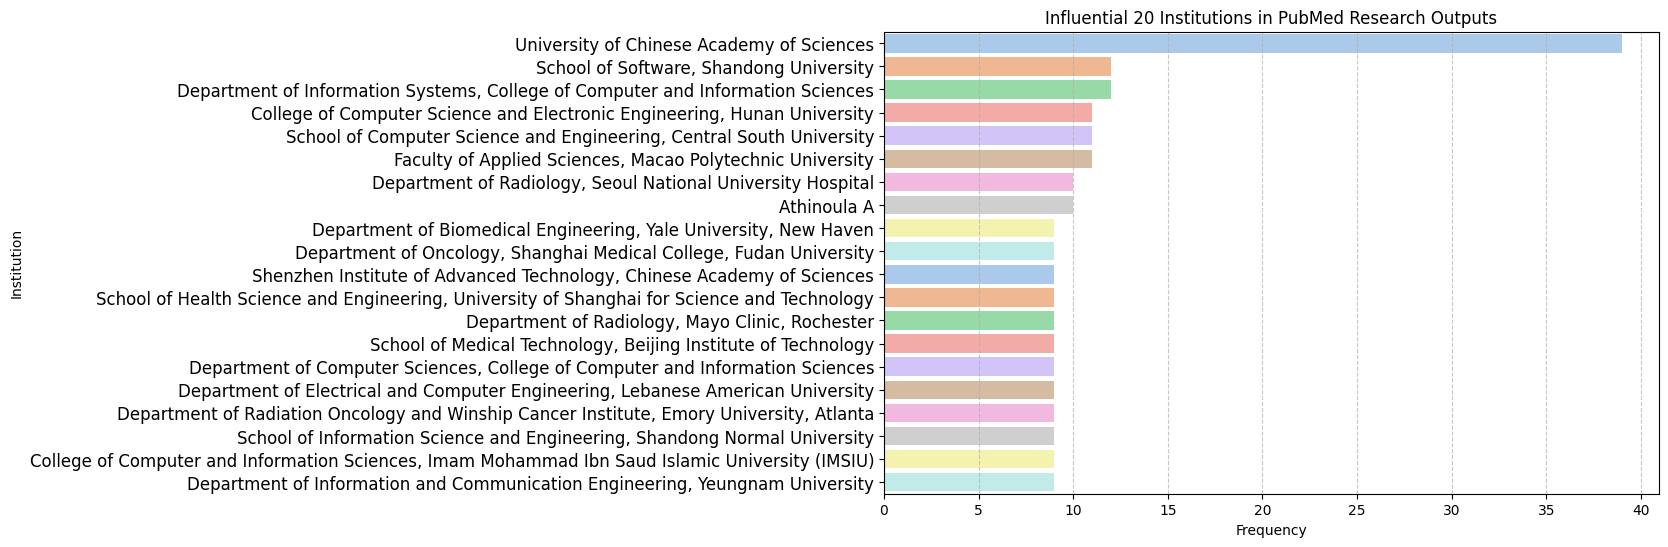

In [213]:
# Most frequent Institution plot 2
# Convert this data into a DataFrame for easier plotting
most_common_institutions = fq_institute.most_common(20)
institutions_df = pd.DataFrame(most_common_institutions, columns=['Institution', 'Frequency'])

# Create a bar plot with the custom palette
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Institution', data=institutions_df, palette='pastel')

plt.title('Influential 20 Institutions in PubMed Research Outputs')
plt.xlabel('Frequency')
plt.ylabel('Institution')

# Improve the readability of the y-axis labels
plt.yticks(fontsize=12, rotation=0, ha='right')

# Optionally, you can add a grid for easier comparison
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Save the plot
plt.savefig('top_20_institutions_pubmed.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

**Geographical Analysis**

In [21]:
# country, city
# Extracting city, country pairs with the updated pattern
pattern = r", ([^,]+)(?:, \d+)?, ([^,]+)$"
city_country_pairs = [re.search(pattern, entry).groups() for entry in institution_lists if re.search(pattern, entry)] #
len(city_country_pairs)
# remove digits
city_country_pairs = [(re.sub(r'\d+', '', city), re.sub(r'\d+', '', country)) for city, country in city_country_pairs]
len(city_country_pairs)
city_country_pairs
# get country
country = [country for city, country in city_country_pairs]
# get city
city = [city for city, country in city_country_pairs]

In [22]:
# country
# remove duplicates
country_list = np.unique(country)

In [23]:
# Provide a standard list of countries
standard_countries = [country.name for country in pycountry.countries] + \
                     [country.alpha_3 for country in pycountry.countries]

In [222]:
# country name cleaning
# Define a function to find the closest country name match
def standardize_country_name(name, country_list):
    # Normalize the input name to upper case for standard comparison
    name_upper = name.upper()
    if not name or name.strip() == '':
        return None

    # Check against ISO alpha-3 codes for an exact match
    for country in pycountry.countries:
        if name_upper == country.alpha_3:
            return country.name

    # Proceed with fuzzy matching if no direct ISO code match found
    # Ensuring the minimum score cutoff for the match and a sequence of three letters in the correct order
    best_match = process.extractOne(name, country_list, score_cutoff=80)
    
    if best_match:
            # Extract the best match's name and normalize it for comparison
            match_name_upper = best_match[0].upper()

            # Check every possible three-letter sequence in 'name_upper' against 'match_name_upper'
            sequence_match = any(name_upper[i:i+3] in match_name_upper for i in range(len(name_upper) - 2))
            if sequence_match:
                return best_match[0]

    # Return None if no suitable match is found
    return None

In [223]:
std_country = [standardize_country_name(country_name, standard_countries) for country_name in tqdm.tqdm(country)]

/Users/liufanling/.local/lib/python3.12/site-packages/tqdm/std.py:580: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
100%|██████████| 31021/31021 [04:08<00:00, 125.05it/s]


In [224]:
std_country_clean = [country for country in std_country if country]

In [225]:
# check frquency of country
fq_country = nltk.FreqDist(std_country_clean)
fq_country.most_common(10)

[('China', 8385),
 ('United States', 4641),
 ('Korea, Republic of', 1626),
 ('Germany', 1340),
 ('Japan', 1033),
 ('India', 974),
 ('Canada', 694),
 ('Italy', 642),
 ('Taiwan, Province of China', 572),
 ('France', 563)]

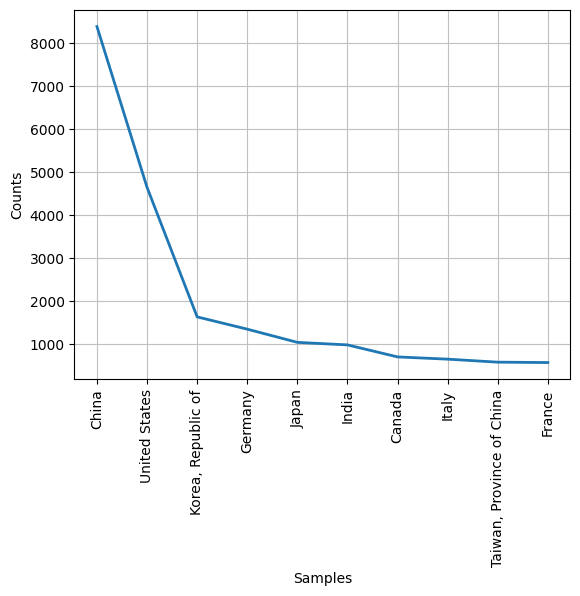

<Axes: xlabel='Samples', ylabel='Counts'>

In [44]:
fq_country.plot(10)

In [164]:
# Interactive map
country_df = pd.DataFrame(std_country_clean, columns=['country'])
# Update 'United States' to 'United States of America' to align with the world map data
country_df['country'] = country_df['country'].replace('United States', 'United States of America')
country_freq = country_df.groupby('country').size().reset_index(name='counts')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(country_freq, left_on='name', right_on='country', how='left')

# Convert GeoDataFrame to GeoJSONDataSource for Bokeh
geosource = GeoJSONDataSource(geojson=world.to_json())

# Define color mapper - this object is useful to color countries based on their frequency
mapper = LinearColorMapper(palette=OrRd[9][::-1], low=country_freq['counts'].min(), high=country_freq['counts'].max(), nan_color='#d9d9d9')

# Initialize the figure
p = figure(title="Frequency of publication in deep learning area between country", height=600, width=950, toolbar_location=None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.title.align = 'center'
# Add the countries to the figure
p.patches('xs', 'ys', source=geosource, fill_color={'field': 'counts', 'transform': mapper}, line_color='black', line_width=0.25, fill_alpha=1)

# Add color bar
color_bar = ColorBar(color_mapper=mapper, label_standoff=8, width=500, height=20, border_line_color=None, location=(0, 0), orientation='horizontal')
p.add_layout(color_bar, 'below')

# Display inline in a Jupyter Notebook
output_notebook()
output_file("country_plot.html")

# Show the plot
show(p)

/var/folders/hz/mtvvz9t52kxgqcx423vlrhx00000gn/T/ipykernel_7423/509597730.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


Loading BokehJS ...

0:130: execution error: 找不到文件“某个对象”。 (-43)


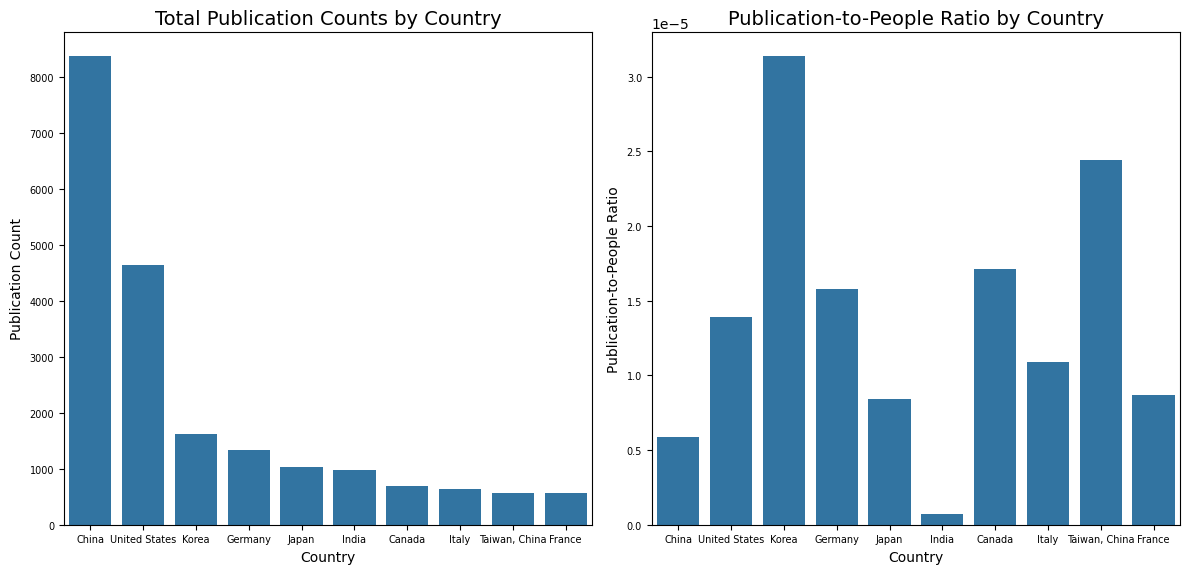

In [185]:
# Calculate and plot the publication-to-people ratio

country_ratio = pd.read_csv("country_population.csv")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
title_fontsize = 14
label_fontsize = 10
tick_fontsize = 7

# Plotting total publication counts
sns.barplot(x='Country', y='publication_count', data=country_ratio, ax=axes[0])
axes[0].set_title('Total Publication Counts by Country', fontsize=title_fontsize)
axes[0].set_ylabel('Publication Count', fontsize=label_fontsize)
axes[0].set_xlabel('Country', fontsize=label_fontsize)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)

# Plotting publication-to-people ratios
sns.barplot(x='Country', y='publication_to_people_ratio', data=country_ratio, ax=axes[1])
axes[1].set_title('Publication-to-People Ratio by Country', fontsize=title_fontsize)
axes[1].set_ylabel('Publication-to-People Ratio', fontsize=label_fontsize)
axes[1].set_xlabel('Country', fontsize=label_fontsize)
axes[1].tick_params(axis='both', labelsize=tick_fontsize)

plt.tight_layout()
plt.savefig('country_population_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# City, country pair
# update country in city_country_pairs
df_city_country = pd.DataFrame({
    'City': city,
    'Country': std_country
})

#  Write the data to a CSV file
df_city_country.to_csv('city_country.csv', index=False)
# Remove duplicates
df_city_country_clean = df_city_country.drop_duplicates()
df_city_country_clean['Country'] = df_city_country_clean['Country'].replace('Korea, Republic of', 'Korea')
df_city_country_clean['Country'] = df_city_country_clean['Country'].replace('United States', 'United States of America')
df_city_country_clean['Country'] = df_city_country_clean['Country'].replace('Iran, Islamic Republic of', 'Iran')
df_city_country_clean.to_csv('city_country_clean.csv', index=False)

In [47]:
def get_city_lat_lon(df):
    lat_lon_cache = {}
    lat_lons = []

    headers = {
        'User-Agent': 'YourAppName',
        'Accept-Language': 'en-US',
    }

    # Use tqdm to wrap the iteration over the DataFrame rows for a progress bar
    for _, row in tqdm.tqdm(df.iterrows(), total=df.shape[0], desc="Fetching coordinates"):
        city, country = row['City'], row['Country']
        cache_key = f"{city}, {country}"

        if cache_key in lat_lon_cache:
            lat_lons.append(lat_lon_cache[cache_key])
        else:
            url = 'https://nominatim.openstreetmap.org/search'
            params = {
                'city': city,
                'country': country,
                'format': 'json',
                'limit': 1
            }
            response = requests.get(url, params=params, headers=headers)
            data = response.json()

            if data:
                latitude = data[0]['lat']
                longitude = data[0]['lon']
                lat_lon_cache[cache_key] = (latitude, longitude)
                lat_lons.append((latitude, longitude))
            else:
                lat_lons.append((None, None))

    return lat_lons

In [ ]:
# not run this line since it takes long time, directly read the csv file
# drop the row of counrty has NA
df_city_country_clean = df_city_country_clean.dropna(subset=['Country'])
# get lat and lon
df_city_country_clean['LatLon'] = get_city_lat_lon(df_city_country_clean)
# Split the 'LatLon' column into separate 'Latitude' and 'Longitude' columns
df_city_country_clean[['Latitude', 'Longitude']] = pd.DataFrame(df_city_country_clean['LatLon'].tolist(), index=df_city_country_clean.index)
# write to csv
df_city_country_clean.to_csv('city_country_latlon.csv', index=False)

In [6]:
df_city_country_clean = pd.read_csv('city_country_latlon.csv')

In [7]:
all_pairs = df_city_country_clean['LatLon'].to_list()
all_pairs = [ast.literal_eval(pair) if isinstance(pair, str) else pair for pair in all_pairs if pair != (None, None)]

# Remove duplicates
all_pairs = list(set(all_pairs))

In [26]:
len(all_pairs)

2034

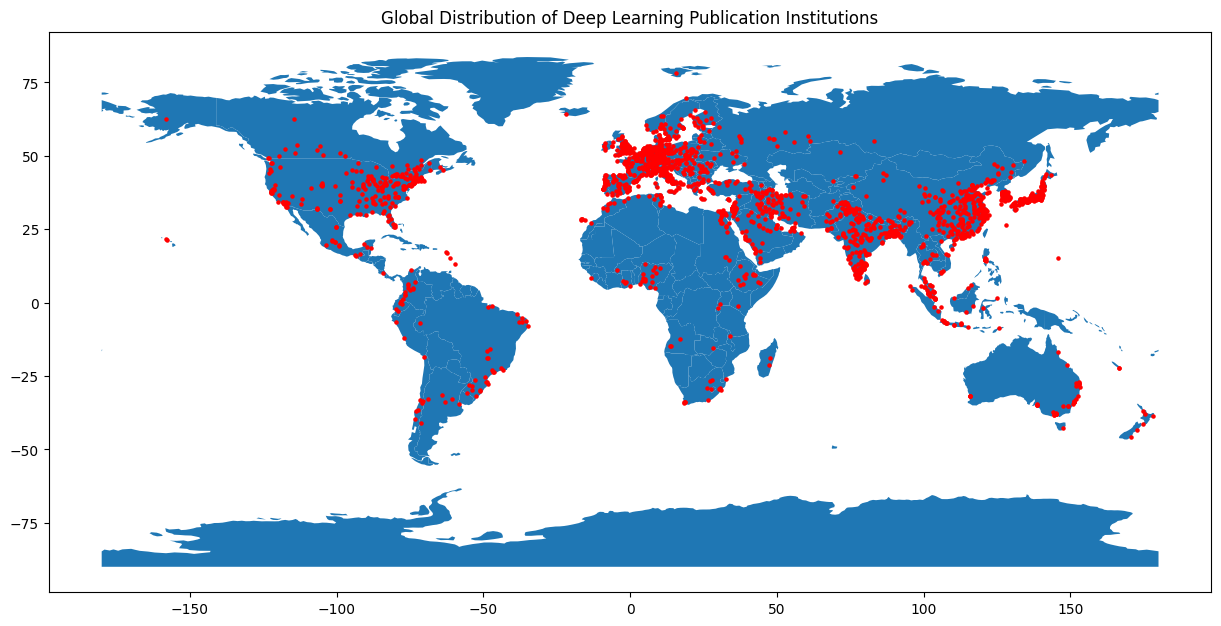

In [8]:
# Convert latitude and longitude to a geographic point and set the geometry
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gpd.GeoDataFrame(all_pairs, columns=['Latitude', 'Longitude'])
gdf['Coordinates'] = gpd.points_from_xy(gdf.Longitude, gdf.Latitude)
gdf = gdf.set_geometry('Coordinates')


# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax)
gdf.plot(ax=ax, color='red', markersize=5)
ax.set_title("Global Distribution of Deep Learning Publication Institutions")
plt.savefig('global_city_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [244]:
# interactive plot
def wgs84_to_web_mercator(df, lon="Longitude", lat="Latitude"):
    k = 6378137  # Radius of the Earth
    df["x"] = df[lon].astype(float) * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat].astype(float)) * np.pi/360.0)) * k
    return df

output_notebook()

# Create a DataFrame from your latitude and longitude pairs
all_pairs_df = pd.DataFrame(all_pairs, columns=['Latitude', 'Longitude'])
all_pairs_df = wgs84_to_web_mercator(all_pairs_df)

# Define the source of data for the map
source = ColumnDataSource(data=dict(x=all_pairs_df['x'], y=all_pairs_df['y']))

# Define the output file
output_file("city_locations.html")


# Define tools to include
TOOLS = "pan,wheel_zoom,reset"
# Create the figure, now specifying the tools
p = figure(
    x_range=(all_pairs_df['x'].min() - 1000, all_pairs_df['x'].max() + 1000),
    y_range=(all_pairs_df['y'].min() - 1000, all_pairs_df['y'].max() + 1000),
    x_axis_type="mercator", y_axis_type="mercator",
    title="Global Distribution of Deep Learning Publication Institutions",
    tools=TOOLS
)

# Add the tile background
tile_provider = get_provider(Vendors.CARTODBPOSITRON)
p.add_tile(tile_provider)

# Add circles at the locations of the cities
p.circle(x='x', y='y', source=source, size=5, color='red', alpha=0.6)

# Display the result in the notebook or output to an HTML file
show(p)

Loading BokehJS ...

0:132: execution error: 找不到文件“某个对象”。 (-43)
